## Imports

In [1]:
import cv2
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchmetrics.segmentation import MeanIoU
import torchvision.utils as vutils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib

## Function to split data into train & val ensuring equal distribution of classes across

In [2]:
def stratified_split(images, masks, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    num_samples = len(images)
    
    # Flatten masks to determine class distributions
    mask_labels = masks.reshape(num_samples, -1).mean(axis=1).astype(int)  # Approx class labels
    
    # Get unique classes and their indices
    unique_classes, class_counts = np.unique(mask_labels, return_counts=True)
    
    train_indices = []
    val_indices = []
    
    for cls in unique_classes:
        cls_indices = np.where(mask_labels == cls)[0]
        np.random.shuffle(cls_indices)
        split_idx = int(len(cls_indices) * (1 - test_size))
        
        train_indices.extend(cls_indices[:split_idx])
        val_indices.extend(cls_indices[split_idx:])
    
    # Shuffle final indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    train_images, val_images = images[train_indices], images[val_indices]
    train_masks, val_masks = masks[train_indices], masks[val_indices]
    
    return train_images, val_images, train_masks, val_masks

## Read Data and split into train and val

In [3]:
def read_images_masks(folder_path, ext=".png"):
    images_folder = f"{folder_path}/images"
    masks_folder = f"{folder_path}/labels"
    file_names = [f for f in os.listdir(images_folder) if f.endswith(ext)]
    all_images = []
    all_masks = []
    for file in file_names:
        all_images.append(cv2.cvtColor(cv2.imread(f"{images_folder}/{file}"), cv2.COLOR_BGR2RGB))
        img = cv2.cvtColor(cv2.imread(f"{masks_folder}/{file}"), cv2.COLOR_BGR2RGB)
        all_masks.append(img[:, :, 0])  # Extract the first channel
    return np.array(all_images), np.array(all_masks)

train_images, train_masks = read_images_masks("/kaggle/input/semantic-segmentation-dataset/dataset_224/train")
train_images, val_images, train_masks, val_masks = stratified_split(train_images, train_masks)
test_images, test_masks = read_images_masks("/kaggle/input/semantic-segmentation-dataset/dataset_224/test")
print(f"Number of train images = {len(train_images)}")
print(f"Number of train masks = {len(train_masks)}")
print(f"Number of val images = {len(val_images)}")
print(f"Number of val masks = {len(val_masks)}")
print(f"Number of test images = {len(test_images)}")
print(f"Number of test masks = {len(test_masks)}")

Number of train images = 1598
Number of train masks = 1598
Number of val images = 402
Number of val masks = 402
Number of test images = 500
Number of test masks = 500


## Shape of images and masks

In [4]:
print(train_images[0].shape, train_masks[0].shape)

(224, 224, 3) (224, 224)


## Map from Class number to class name and defining the segmentation color map

In [5]:
_class = {
    0: "Unlabelled",
    1: "Building",
    2: "Fence",
    3: "Other",
    4: "Pedestrian",
    5: "Pole",
    6: "Roadline",
    7: "Road",
    8: "Sidewalk",
    9: "Vegetation",
    10: "Car",
    11: "Wall",
    12: "Traffic Sign"
}

seg_map = 'jet'

## Visualising Data

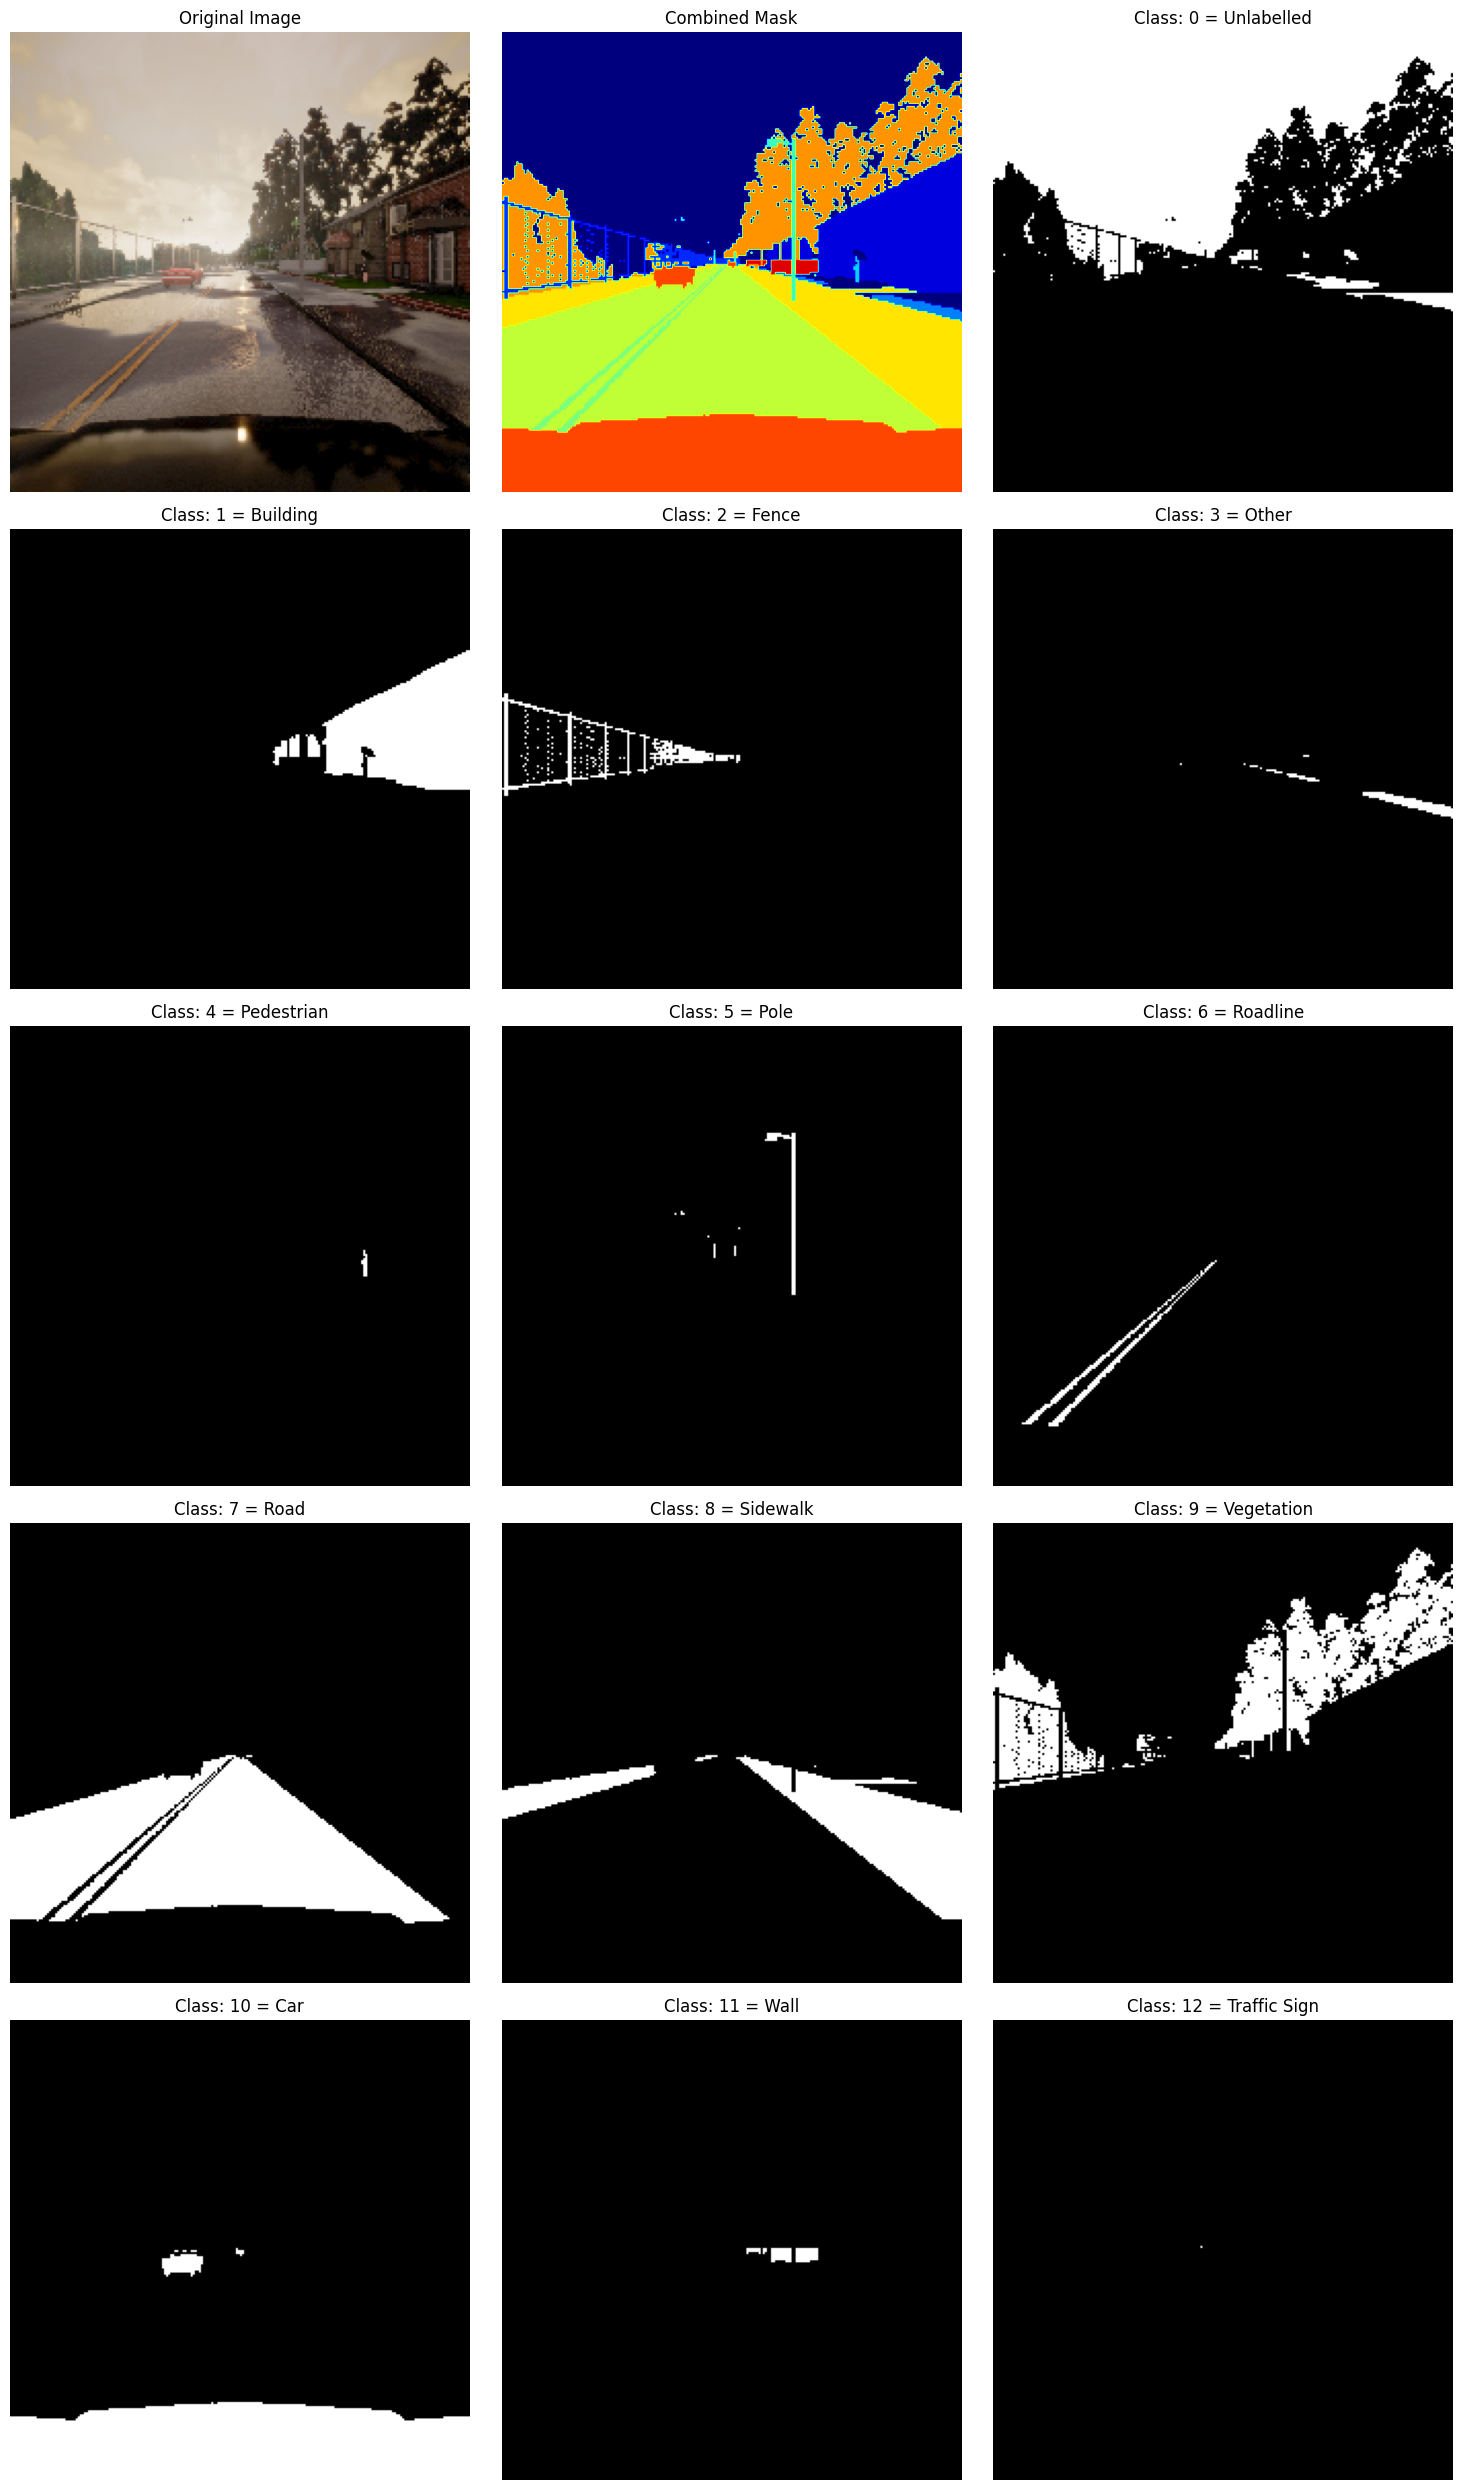

In [6]:
def visualise_masks(img_arr, mask_arr):
    samples_visualised = 0
    
    for img, mask in zip(img_arr, mask_arr):        
        # List of all the classes present in the mask/image
        classes_present = np.unique(mask)

        # Plot only the good masks where all the classes are present
        if len(classes_present) == 13:
            fig, axes = plt.subplots(5, 3, figsize=(15, 25)) # Original Image + Combined Mask + Individual Masks = 15 total images
            axes = axes.ravel()
            
            axes[0].imshow(img)
            axes[0].axis('off')
            axes[0].set_title("Original Image")

            axes[1].imshow(mask, cmap=seg_map)
            axes[1].axis('off')
            axes[1].set_title("Combined Mask")
            
            for idx, cls in enumerate(classes_present):
                binary_mask = np.where(mask == cls, 1, 0)
                axes[idx + 2].imshow(binary_mask, cmap='gray')
                axes[idx + 2].axis('off')
                axes[idx + 2].set_title(f"Class: {cls} = {_class[cls]}")
            plt.tight_layout()
            plt.show()

            break

visualise_masks(train_images, train_masks)

## Main model class

In [ ]:
class VGG16_FCN(nn.Module):
    def __init__(self, num_classes=13, freeze_feat_extractor=False, variant='8s'):
        super(VGG16_FCN, self).__init__()
        self.n_classes = num_classes
        self.variant = variant
        
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg16.features # Taking out all the initial layers except the last fully connected layers

        if freeze_feat_extractor:
            for param in self.features.parameters():
                param.requires_grad = False

        """
            The output of the features layers is 7x7x512 (for Imagenet size 
            images - can be more for larger images, if smaller then we will 
            need to adjust this as 7x7 will be a larger kernel) so we are 
            using 4096 kernels of 7x7 size to convert to 1x1x4096 sized 
            vector (similar to fully connected layer), and all the inputs
            for this question are in the 224x224 size so going ahead with
            7x7x512 sized kernels (4096 in numbers)
        """
        self.conv_classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(4096, 4096, kernel_size=1),  # Similarly going from 4096 to 4096 features using 4096 kernels of shape 1x1x4096
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Conv2d(4096, num_classes, kernel_size=1)
            # This has finally reduced the output feature map size to be 32 times smaller than the input image (in HxW)
        )

        self.upsample_32x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)
        self.upsample_16x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)

        # Since pool4 and pool3 feature maps won't have num_classes channels we need to pass them through a conv layer to convert them to 21 channeled through 1x1 kernels
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        pool3_out = None
        pool4_out = None
        
        for i in range(len(self.features)):
            x = self.features[i](x)
            if i == 16:  # pool3
                pool3_out = x
            elif i == 23:  # pool4
                pool4_out = x
        
        x = self.conv_classifier(x)
        
        if self.variant == '32s':
            xs = self.upsample_32x(x)
            
        elif self.variant == '16s':
            score_pool4 = self.score_pool4(pool4_out)
            x_2x = self.upsample_2x(x)
            combined = score_pool4 + x_2x
            xs = self.upsample_16x(combined)
            
        elif self.variant == '8s':
            score_pool4 = self.score_pool4(pool4_out)
            x_2x = self.upsample_2x(x)
            combined_16s = score_pool4 + x_2x
            
            score_pool3 = self.score_pool3(pool3_out)
            combined_16s_2x = self.upsample_2x(combined_16s)
            combined_8s = score_pool3 + combined_16s_2x 
            
            xs = self.upsample_8x(combined_8s)
        
        return xs

    def train_model(self, train_loader, val_loader, device, num_epochs=20, lr=1e-4, optimiser='adam', loss_func='cross_entropy'):
        if loss_func == 'cross_entropy':
            criterion = nn.CrossEntropyLoss()
        
        trainable_params = [p for p in self.parameters() if p.requires_grad]
        if optimiser == 'sgd':
            optimiser = optim.SGD(trainable_params, lr=lr)
        elif optimiser == 'adam':
            optimiser = optim.Adam(trainable_params, lr=lr)
            
        # Metrics
        miou_metric = MeanIoU(num_classes=self.n_classes).to(device)
        
        # Training loop
        train_losses, val_losses = [], []
        train_miou, val_miou = [], []
        
        for epoch in range(num_epochs):
            self.train()
            epoch_loss, epoch_miou = 0, 0
            
            train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
        
            for images, masks in train_loader_tqdm:
                images, masks = images.to(device), masks.to(device)
        
                optimiser.zero_grad()
                preds = self.forward(images)
        
                loss = criterion(preds, masks)
                loss.backward()
                optimiser.step()
        
                # Calculate batch metrics
                epoch_loss += loss.item()
                pred_classes = torch.argmax(preds, dim=1)  # Convert [B, 13, H, W] to [B, H, W]
                epoch_miou += miou_metric(pred_classes, masks).item()
        
                train_loader_tqdm.set_postfix(loss=loss.item())
        
            train_losses.append(epoch_loss / len(train_loader))
            train_miou.append(epoch_miou / len(train_loader))
        
            # Validation
            self.eval()
            val_loss, val_miou_score = 0, 0
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        
            with torch.no_grad():
                for images, masks in val_loader_tqdm:
                    images, masks = images.to(device), masks.to(device)
                    preds = self.forward(images)
        
                    loss = criterion(preds, masks)
                    val_loss += loss.item()
        
                    pred_classes = torch.argmax(preds, dim=1)  # Convert [B, 13, H, W] to [B, H, W]
                    val_miou_score += miou_metric(pred_classes, masks).item()
        
                    val_loader_tqdm.set_postfix(loss=loss.item())
        
            val_losses.append(val_loss / len(val_loader))
            val_miou.append(val_miou_score / len(val_loader))
        
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss={round(train_losses[-1], 4)}, Val Loss={round(val_losses[-1], 4)}, Train mIoU={round(train_miou[-1], 4)}, Val mIoU={round(val_miou[-1], 4)}") 

        return train_losses, train_miou, val_losses, val_miou

    def test_model(self, test_loader, device, loss_func='cross_entropy'):
        if loss_func == 'cross_entropy':
            criterion = nn.CrossEntropyLoss()

        miou_metric = MeanIoU(num_classes=self.n_classes).to(device)

        test_loss, test_miou_score = 0, 0
        all_predictions = []
    
        self.eval()
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                preds = self.forward(images)
    
                loss = criterion(preds, masks)
                test_loss += loss.item()

                pred_classes = torch.argmax(preds, dim=1)
                test_miou_score += miou_metric(pred_classes, masks).item()

                for pred in preds:
                    all_predictions.append(torch.argmax(pred, dim=0).cpu().numpy())

        return all_predictions, test_loss / len(test_loader), test_miou_score / len(test_loader)

## Dataset class and dataloader

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
        
        return image, mask

# Load datasets
train_dataset = SegmentationDataset(train_images, train_masks)
val_dataset = SegmentationDataset(val_images, val_masks)
test_dataset = SegmentationDataset(test_images, test_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Instantiate Frozen Backbone models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn_32s = VGG16_FCN(freeze_feat_extractor=True, variant='32s').to(device)
fcn_16s = VGG16_FCN(freeze_feat_extractor=True, variant='16s').to(device)
fcn_8s = VGG16_FCN(freeze_feat_extractor=True, variant='8s').to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 215MB/s]


## Function to plot loss and mIoU graphs

In [10]:
def plot_loss_miou_outputs(train_losses, train_miou, val_losses, val_miou, preds):
    sns.set_style("whitegrid")
    sns.set_palette("pastel")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].plot(train_losses, label="Train Loss", linestyle='-', marker='o')
    axes[0].plot(val_losses, label="Val Loss", linestyle='-', marker='s')
    axes[0].set_title("Loss", fontsize=14)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    
    axes[1].plot(train_miou, label="Train mIoU", linestyle='-', marker='o')
    axes[1].plot(val_miou, label="Val mIoU", linestyle='-', marker='s')
    axes[1].set_title("Mean IoU (mIoU)", fontsize=14)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("mIoU Score")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 5, figsize=(12, 5))
    for i in range(5):
        axes[i].imshow(preds[i], cmap=seg_map)
        axes[i].axis('off')

    plt.suptitle("Some Predictions Visualised")
    plt.tight_layout()
    plt.show()

## Training model FCN-32s (Backbone Frozen)

In [11]:
losses_mious_32s = list(fcn_32s.train_model(train_loader, val_loader, device))

print("\nTest Stats:")
x_32s, test_loss_32s, test_miou_32s = fcn_32s.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_32s, 4)}")
print(f"Test mIoU = {round(test_miou_32s, 4)}")

Epoch 1/20: Train Loss=0.7016, Val Loss=0.4148, Train mIoU=0.5459, Val mIoU=0.6623


Epoch 2/20: Train Loss=0.37, Val Loss=0.3472, Train mIoU=0.6809, Val mIoU=0.6972


Epoch 3/20: Train Loss=0.3197, Val Loss=0.3206, Train mIoU=0.704, Val mIoU=0.6961


Epoch 4/20: Train Loss=0.2929, Val Loss=0.2998, Train mIoU=0.716, Val mIoU=0.711


Epoch 5/20: Train Loss=0.2764, Val Loss=0.2944, Train mIoU=0.7238, Val mIoU=0.7258


Epoch 6/20: Train Loss=0.2618, Val Loss=0.2786, Train mIoU=0.7318, Val mIoU=0.7279


Epoch 7/20: Train Loss=0.2483, Val Loss=0.2726, Train mIoU=0.7403, Val mIoU=0.7369


Epoch 8/20: Train Loss=0.2393, Val Loss=0.2663, Train mIoU=0.7462, Val mIoU=0.7363


Epoch 9/20: Train Loss=0.2306, Val Loss=0.2582, Train mIoU=0.751, Val mIoU=0.7381


Epoch 10/20: Train Loss=0.2244, Val Loss=0.251, Train mIoU=0.7554, Val mIoU=0.7455


Epoch 11/20: Train Loss=0.2182, Val Loss=0.2483, Train mIoU=0.7585, Val mIoU=0.7442


Epoch 12/20: Train Loss=0.2138, Val Loss=0.2454, Train mIoU=0.762, Val mIoU=0.7424


Epoch 13/20: Train Loss=0.2093, Val Loss=0.2413, Train mIoU=0.7646, Val mIoU=0.7462


Epoch 14/20: Train Loss=0.2049, Val Loss=0.2399, Train mIoU=0.7671, Val mIoU=0.7518


Epoch 15/20: Train Loss=0.2014, Val Loss=0.2375, Train mIoU=0.7694, Val mIoU=0.7534


Epoch 16/20: Train Loss=0.1978, Val Loss=0.2344, Train mIoU=0.7713, Val mIoU=0.752


Epoch 17/20: Train Loss=0.1943, Val Loss=0.2343, Train mIoU=0.7742, Val mIoU=0.7509


Epoch 18/20: Train Loss=0.1909, Val Loss=0.2316, Train mIoU=0.7762, Val mIoU=0.7576


Epoch 19/20: Train Loss=0.1882, Val Loss=0.2324, Train mIoU=0.7783, Val mIoU=0.7499


Epoch 20/20: Train Loss=0.1857, Val Loss=0.2283, Train mIoU=0.7795, Val mIoU=0.7563

Test Stats:
Test loss = 0.2277
Test mIoU = 0.756


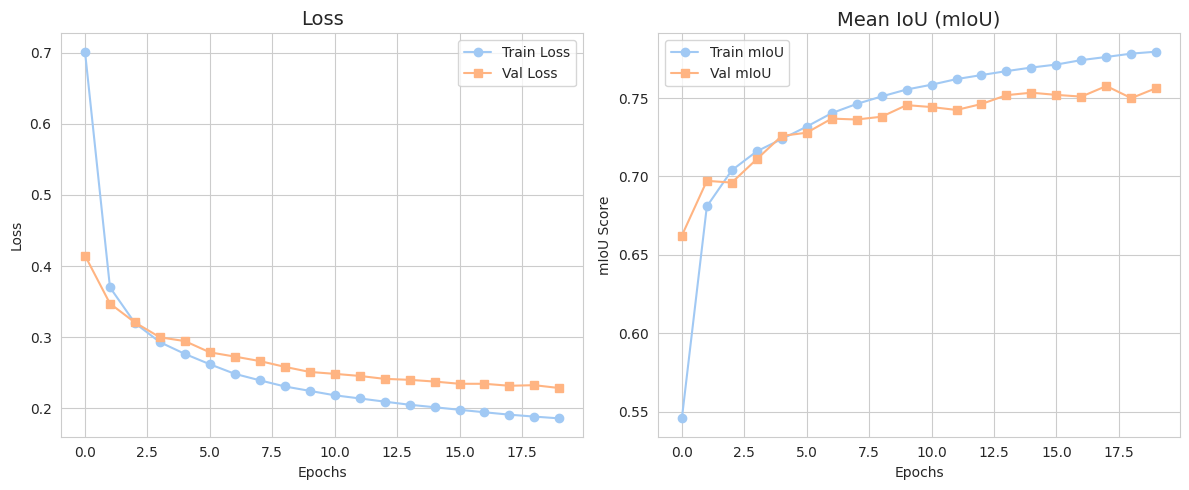

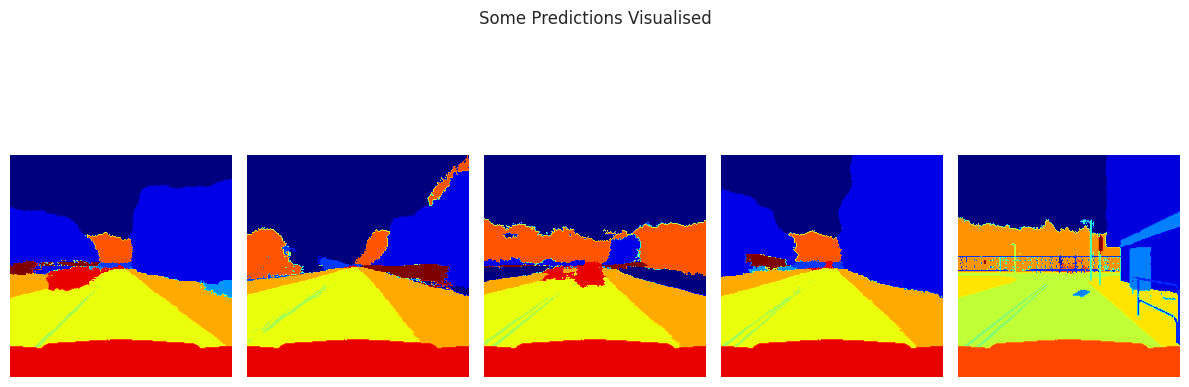

In [12]:
plot_loss_miou_outputs(*losses_mious_32s, x_32s)

## Training model FCN-16s (Backbone Frozen)

In [13]:
losses_mious_16s = list(fcn_16s.train_model(train_loader, val_loader, device))

print("\nTest Stats:")
x_16s, test_loss_16s, test_miou_16s = fcn_16s.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_16s, 4)}")
print(f"Test mIoU = {round(test_miou_16s, 4)}")

Epoch 1/20: Train Loss=0.8777, Val Loss=0.4235, Train mIoU=0.5354, Val mIoU=0.6844


Epoch 2/20: Train Loss=0.367, Val Loss=0.3352, Train mIoU=0.7049, Val mIoU=0.7166


Epoch 3/20: Train Loss=0.3058, Val Loss=0.3023, Train mIoU=0.7288, Val mIoU=0.7267


Epoch 4/20: Train Loss=0.2758, Val Loss=0.2818, Train mIoU=0.7415, Val mIoU=0.7331


Epoch 5/20: Train Loss=0.256, Val Loss=0.2656, Train mIoU=0.7501, Val mIoU=0.7472


Epoch 6/20: Train Loss=0.2417, Val Loss=0.2564, Train mIoU=0.7566, Val mIoU=0.7507


Epoch 7/20: Train Loss=0.2313, Val Loss=0.2482, Train mIoU=0.7614, Val mIoU=0.7516


Epoch 8/20: Train Loss=0.2228, Val Loss=0.2436, Train mIoU=0.7654, Val mIoU=0.7573


Epoch 9/20: Train Loss=0.2165, Val Loss=0.2398, Train mIoU=0.7684, Val mIoU=0.758


Epoch 10/20: Train Loss=0.2106, Val Loss=0.234, Train mIoU=0.7717, Val mIoU=0.7613


Epoch 11/20: Train Loss=0.2062, Val Loss=0.2348, Train mIoU=0.7737, Val mIoU=0.7613


Epoch 12/20: Train Loss=0.2018, Val Loss=0.2291, Train mIoU=0.7762, Val mIoU=0.763


Epoch 13/20: Train Loss=0.1981, Val Loss=0.2275, Train mIoU=0.778, Val mIoU=0.7654


Epoch 14/20: Train Loss=0.1952, Val Loss=0.2269, Train mIoU=0.7796, Val mIoU=0.7653


Epoch 15/20: Train Loss=0.192, Val Loss=0.2236, Train mIoU=0.7813, Val mIoU=0.7671


Epoch 16/20: Train Loss=0.1893, Val Loss=0.223, Train mIoU=0.7826, Val mIoU=0.7676


Epoch 17/20: Train Loss=0.1872, Val Loss=0.2231, Train mIoU=0.7839, Val mIoU=0.7654


Epoch 18/20: Train Loss=0.1845, Val Loss=0.2201, Train mIoU=0.7853, Val mIoU=0.7704


Epoch 19/20: Train Loss=0.1825, Val Loss=0.2186, Train mIoU=0.7867, Val mIoU=0.7673


Epoch 20/20: Train Loss=0.1803, Val Loss=0.2194, Train mIoU=0.7877, Val mIoU=0.7714

Test Stats:
Test loss = 0.2205
Test mIoU = 0.7697


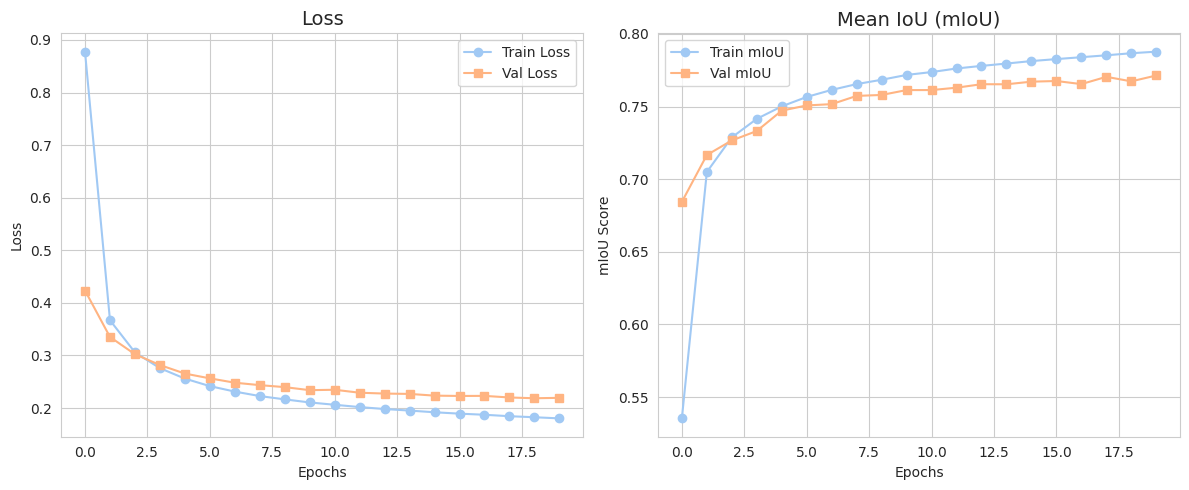

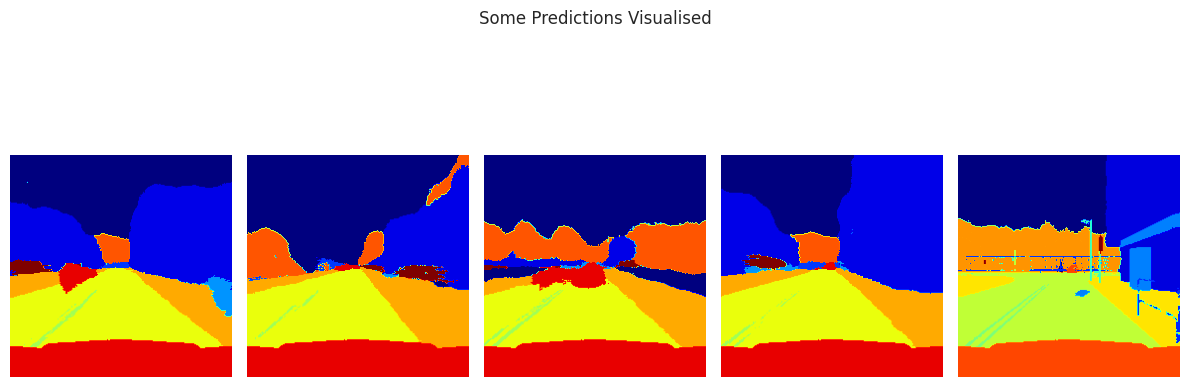

In [14]:
plot_loss_miou_outputs(*losses_mious_16s, x_16s)

## Training model FCN-8s (Backbone Frozen)

In [15]:
losses_mious_8s = list(fcn_8s.train_model(train_loader, val_loader, device))

print("\nTest Stats:")
x_8s, test_loss_8s, test_miou_8s = fcn_8s.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_8s, 4)}")
print(f"Test mIoU = {round(test_miou_8s, 4)}")

Epoch 1/20: Train Loss=2.4662, Val Loss=0.8047, Train mIoU=0.441, Val mIoU=0.6136


Epoch 2/20: Train Loss=0.5846, Val Loss=0.4599, Train mIoU=0.6644, Val mIoU=0.7043


Epoch 3/20: Train Loss=0.3955, Val Loss=0.3621, Train mIoU=0.7217, Val mIoU=0.7309


Epoch 4/20: Train Loss=0.3261, Val Loss=0.3177, Train mIoU=0.7447, Val mIoU=0.7504


Epoch 5/20: Train Loss=0.2893, Val Loss=0.2912, Train mIoU=0.7578, Val mIoU=0.7559


Epoch 6/20: Train Loss=0.2659, Val Loss=0.2708, Train mIoU=0.7665, Val mIoU=0.7656


Epoch 7/20: Train Loss=0.2499, Val Loss=0.2586, Train mIoU=0.7726, Val mIoU=0.7714


Epoch 8/20: Train Loss=0.2368, Val Loss=0.2487, Train mIoU=0.7782, Val mIoU=0.7769


Epoch 9/20: Train Loss=0.2268, Val Loss=0.2396, Train mIoU=0.7822, Val mIoU=0.7768


Epoch 10/20: Train Loss=0.2189, Val Loss=0.2327, Train mIoU=0.7856, Val mIoU=0.7812


Epoch 11/20: Train Loss=0.212, Val Loss=0.2268, Train mIoU=0.7883, Val mIoU=0.7835


Epoch 12/20: Train Loss=0.206, Val Loss=0.2228, Train mIoU=0.7911, Val mIoU=0.7867


Epoch 13/20: Train Loss=0.2017, Val Loss=0.2198, Train mIoU=0.7932, Val mIoU=0.7857


Epoch 14/20: Train Loss=0.197, Val Loss=0.2175, Train mIoU=0.7952, Val mIoU=0.7874


Epoch 15/20: Train Loss=0.1938, Val Loss=0.2124, Train mIoU=0.7963, Val mIoU=0.789


Epoch 16/20: Train Loss=0.1898, Val Loss=0.2101, Train mIoU=0.7981, Val mIoU=0.7898


Epoch 17/20: Train Loss=0.1874, Val Loss=0.2094, Train mIoU=0.7996, Val mIoU=0.7907


Epoch 18/20: Train Loss=0.1842, Val Loss=0.2064, Train mIoU=0.8007, Val mIoU=0.7936


Epoch 19/20: Train Loss=0.1814, Val Loss=0.2031, Train mIoU=0.8023, Val mIoU=0.7939


Epoch 20/20: Train Loss=0.1795, Val Loss=0.2027, Train mIoU=0.8034, Val mIoU=0.7922

Test Stats:
Test loss = 0.204
Test mIoU = 0.7904


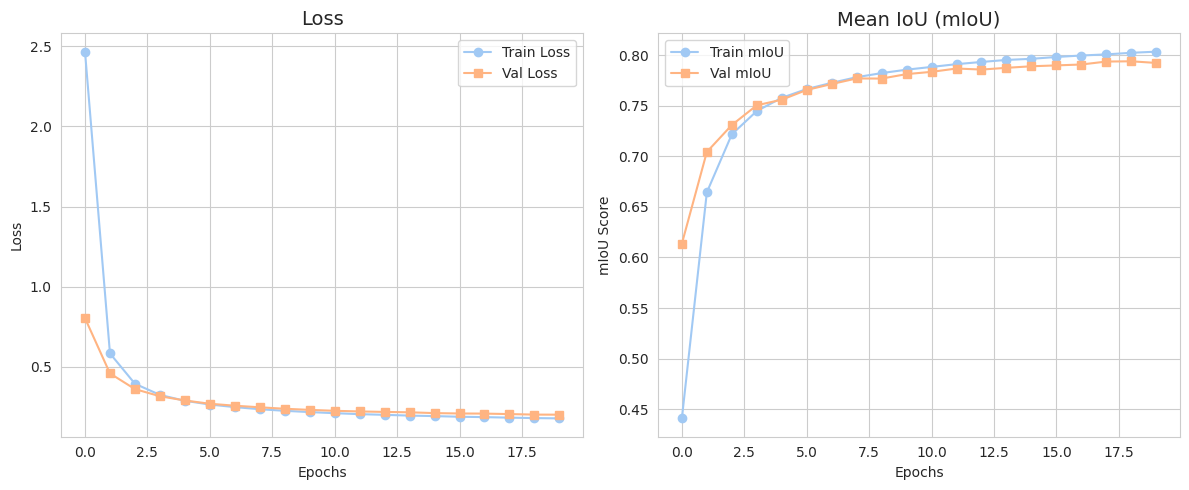

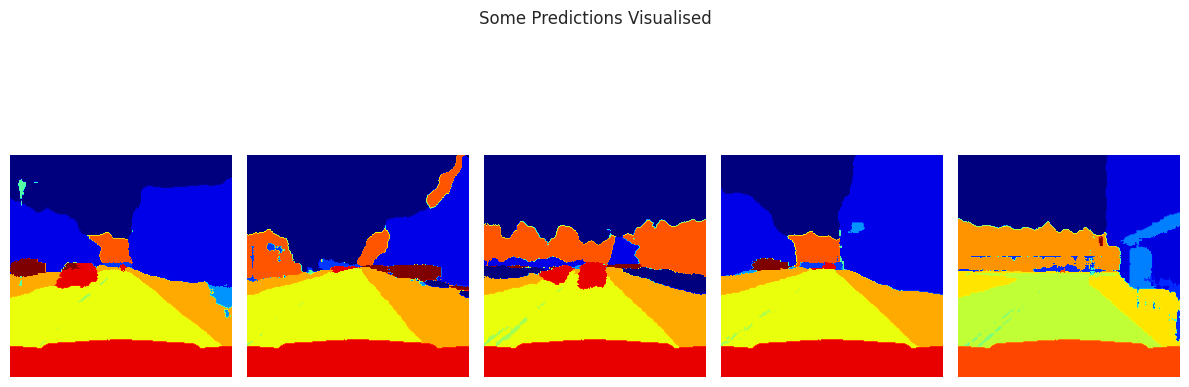

In [16]:
plot_loss_miou_outputs(*losses_mious_8s, x_8s)

## Visualising outputs side by side

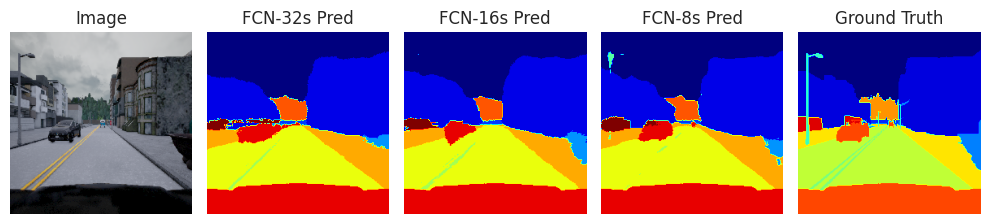

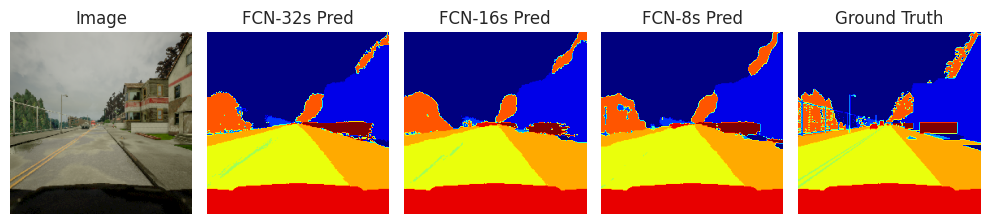

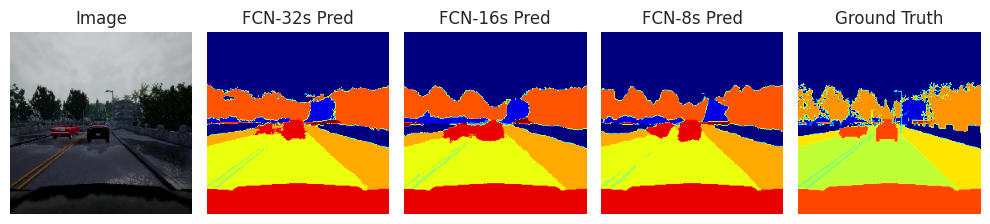

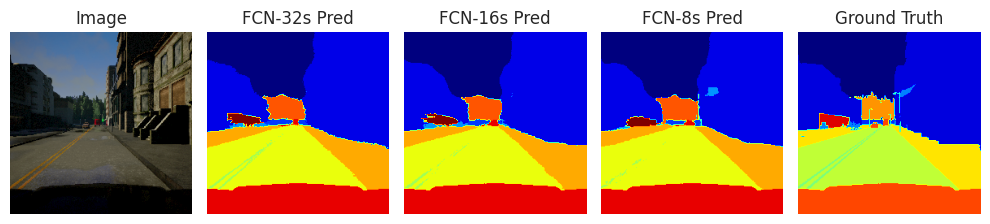

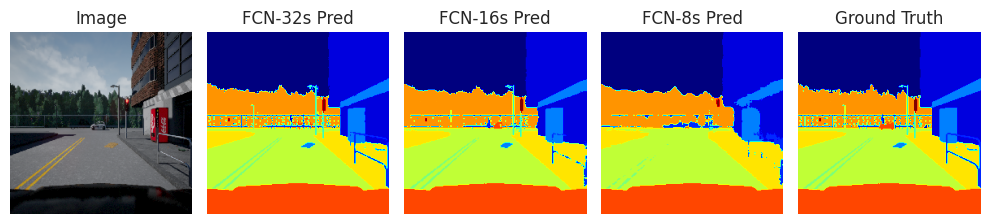

In [17]:
for i in range(5):
    fig, axes = plt.subplots(1, 5, figsize=(10, 25))
    
    axes[0].imshow(np.int32(test_images[i]))
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(x_32s[i], cmap=seg_map)
    axes[1].set_title("FCN-32s Pred")
    axes[1].axis('off')

    axes[2].imshow(x_16s[i], cmap=seg_map)
    axes[2].set_title("FCN-16s Pred")
    axes[2].axis('off')

    axes[3].imshow(x_8s[i], cmap=seg_map)
    axes[3].set_title("FCN-8s Pred")
    axes[3].axis('off')
    
    axes[4].imshow(test_masks[i], cmap=seg_map)
    axes[4].set_title("Ground Truth")
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()

## Instantiating models (Unfrozen Backbone)

In [18]:
fcn_32s_unfrozen = VGG16_FCN(freeze_feat_extractor=False, variant='32s').to(device)
fcn_16s_unfrozen = VGG16_FCN(freeze_feat_extractor=False, variant='16s').to(device)
fcn_8s_unfrozen = VGG16_FCN(freeze_feat_extractor=False, variant='8s').to(device)

## Training FCN-32s (Unfrozen Backbone)

In [19]:
losses_mious_32s_unfrozen = list(fcn_32s_unfrozen.train_model(train_loader, val_loader, device))

print("\nTest Stats:")
x_32s_unfrozen, test_loss_32s_unfrozen, test_miou_32s_unfrozen = fcn_32s_unfrozen.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_32s_unfrozen, 4)}")
print(f"Test mIoU = {round(test_miou_32s_unfrozen, 4)}")

Epoch 1/20: Train Loss=0.6501, Val Loss=0.3481, Train mIoU=0.5804, Val mIoU=0.7083


Epoch 2/20: Train Loss=0.3166, Val Loss=0.2893, Train mIoU=0.712, Val mIoU=0.7238


Epoch 3/20: Train Loss=0.2744, Val Loss=0.2624, Train mIoU=0.7305, Val mIoU=0.7378


Epoch 4/20: Train Loss=0.2496, Val Loss=0.2516, Train mIoU=0.745, Val mIoU=0.7494


Epoch 5/20: Train Loss=0.2333, Val Loss=0.2362, Train mIoU=0.7548, Val mIoU=0.7576


Epoch 6/20: Train Loss=0.2208, Val Loss=0.2277, Train mIoU=0.762, Val mIoU=0.763


Epoch 7/20: Train Loss=0.2101, Val Loss=0.2171, Train mIoU=0.7685, Val mIoU=0.7667


Epoch 8/20: Train Loss=0.2024, Val Loss=0.2105, Train mIoU=0.7727, Val mIoU=0.7739


Epoch 9/20: Train Loss=0.1944, Val Loss=0.205, Train mIoU=0.7776, Val mIoU=0.7735


Epoch 10/20: Train Loss=0.1881, Val Loss=0.1997, Train mIoU=0.7811, Val mIoU=0.7789


Epoch 11/20: Train Loss=0.1831, Val Loss=0.1956, Train mIoU=0.7845, Val mIoU=0.7814


Epoch 12/20: Train Loss=0.1771, Val Loss=0.1941, Train mIoU=0.7884, Val mIoU=0.7796


Epoch 13/20: Train Loss=0.1732, Val Loss=0.1885, Train mIoU=0.7906, Val mIoU=0.7855


Epoch 14/20: Train Loss=0.1691, Val Loss=0.1857, Train mIoU=0.7932, Val mIoU=0.7851


Epoch 15/20: Train Loss=0.1659, Val Loss=0.1844, Train mIoU=0.7954, Val mIoU=0.787


Epoch 16/20: Train Loss=0.1628, Val Loss=0.1836, Train mIoU=0.7973, Val mIoU=0.7853


Epoch 17/20: Train Loss=0.1603, Val Loss=0.1809, Train mIoU=0.7992, Val mIoU=0.7871


Epoch 18/20: Train Loss=0.1578, Val Loss=0.1787, Train mIoU=0.8006, Val mIoU=0.7892


Epoch 19/20: Train Loss=0.1558, Val Loss=0.1799, Train mIoU=0.8023, Val mIoU=0.789


Epoch 20/20: Train Loss=0.1539, Val Loss=0.1765, Train mIoU=0.8038, Val mIoU=0.7913

Test Stats:
Test loss = 0.1777
Test mIoU = 0.7891


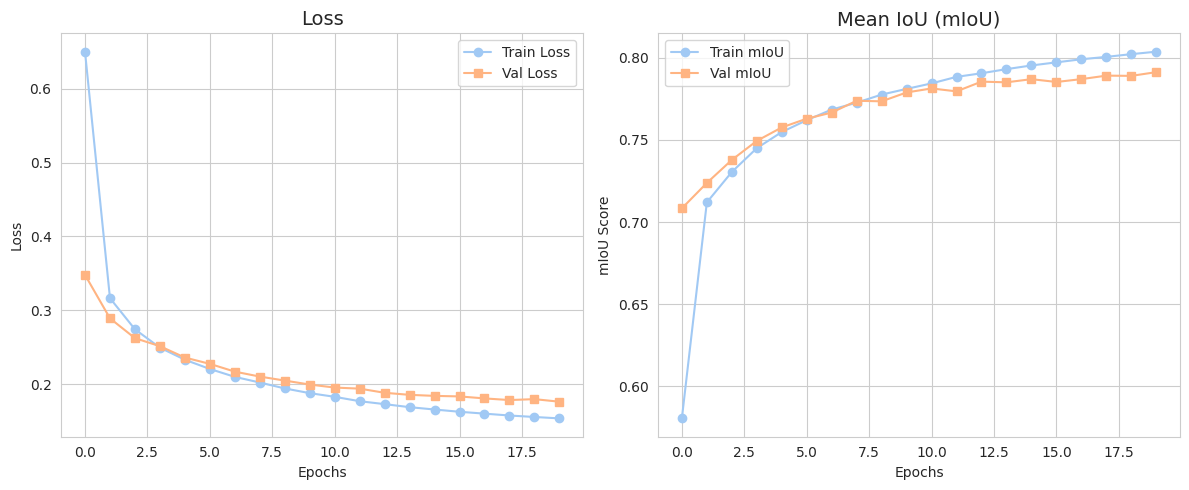

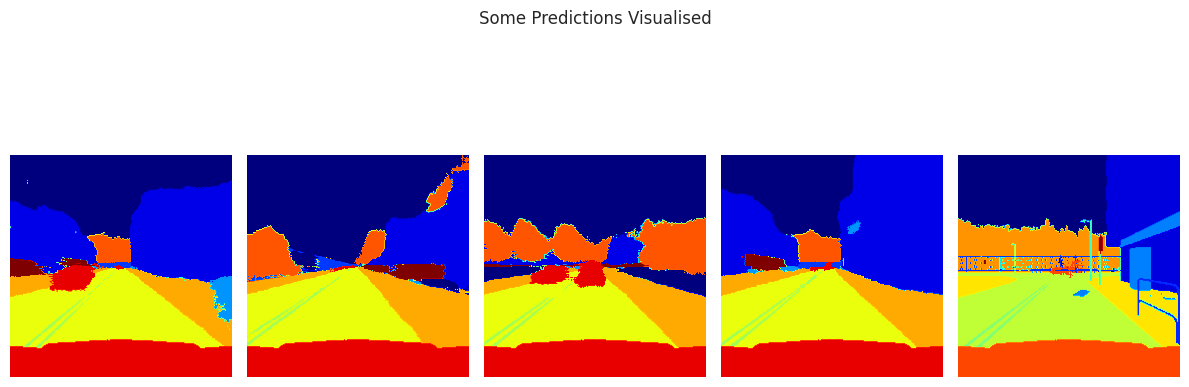

In [20]:
plot_loss_miou_outputs(*losses_mious_32s_unfrozen, x_32s_unfrozen)

## Training FCN-16s (Unfrozen Backbone)

In [21]:
losses_mious_16s_unfrozen = list(fcn_16s_unfrozen.train_model(train_loader, val_loader, device))

print("\nTest Stats:")
x_16s_unfrozen, test_loss_16s_unfrozen, test_miou_16s_unfrozen = fcn_16s_unfrozen.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_16s_unfrozen, 4)}")
print(f"Test mIoU = {round(test_miou_16s_unfrozen, 4)}")

Epoch 1/20: Train Loss=0.7381, Val Loss=0.321, Train mIoU=0.5982, Val mIoU=0.7414


Epoch 2/20: Train Loss=0.2727, Val Loss=0.252, Train mIoU=0.7538, Val mIoU=0.7568


Epoch 3/20: Train Loss=0.2235, Val Loss=0.2175, Train mIoU=0.7747, Val mIoU=0.7783


Epoch 4/20: Train Loss=0.1979, Val Loss=0.1999, Train mIoU=0.7869, Val mIoU=0.7842


Epoch 5/20: Train Loss=0.1789, Val Loss=0.1838, Train mIoU=0.796, Val mIoU=0.7947


Epoch 6/20: Train Loss=0.1662, Val Loss=0.1775, Train mIoU=0.8024, Val mIoU=0.798


Epoch 7/20: Train Loss=0.1577, Val Loss=0.171, Train mIoU=0.8069, Val mIoU=0.7993


Epoch 8/20: Train Loss=0.15, Val Loss=0.1654, Train mIoU=0.8116, Val mIoU=0.802


Epoch 9/20: Train Loss=0.144, Val Loss=0.162, Train mIoU=0.8155, Val mIoU=0.8071


Epoch 10/20: Train Loss=0.1391, Val Loss=0.1584, Train mIoU=0.8188, Val mIoU=0.8103


Epoch 11/20: Train Loss=0.135, Val Loss=0.1567, Train mIoU=0.8214, Val mIoU=0.8102


Epoch 12/20: Train Loss=0.1315, Val Loss=0.1542, Train mIoU=0.8238, Val mIoU=0.8132


Epoch 13/20: Train Loss=0.1283, Val Loss=0.1536, Train mIoU=0.826, Val mIoU=0.8145


Epoch 14/20: Train Loss=0.1254, Val Loss=0.1521, Train mIoU=0.8281, Val mIoU=0.8139


Epoch 15/20: Train Loss=0.1228, Val Loss=0.1498, Train mIoU=0.8299, Val mIoU=0.8174


Epoch 16/20: Train Loss=0.1203, Val Loss=0.1487, Train mIoU=0.8317, Val mIoU=0.8164


Epoch 17/20: Train Loss=0.118, Val Loss=0.1482, Train mIoU=0.8337, Val mIoU=0.8166


Epoch 18/20: Train Loss=0.1163, Val Loss=0.1469, Train mIoU=0.8347, Val mIoU=0.8192


Epoch 19/20: Train Loss=0.1142, Val Loss=0.1463, Train mIoU=0.8361, Val mIoU=0.8205


Epoch 20/20: Train Loss=0.1127, Val Loss=0.1484, Train mIoU=0.8372, Val mIoU=0.8192

Test Stats:
Test loss = 0.1501
Test mIoU = 0.8175


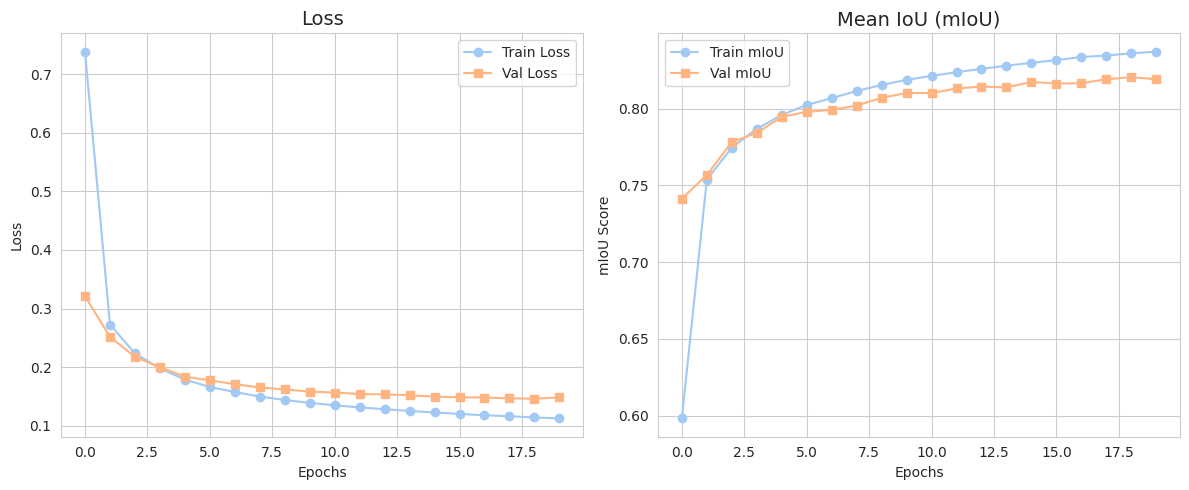

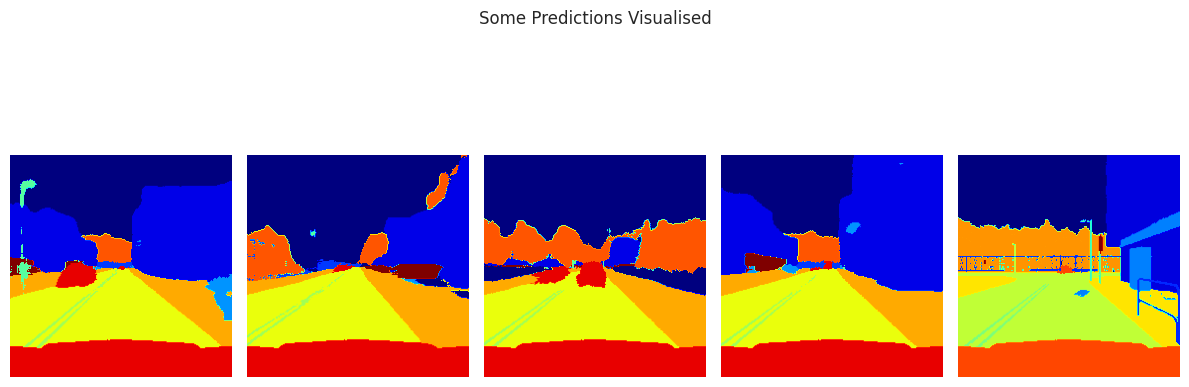

In [22]:
plot_loss_miou_outputs(*losses_mious_16s_unfrozen, x_16s_unfrozen)

## Training FCN-8s (Unfrozen Backbone)

In [23]:
losses_mious_8s_unfrozen = list(fcn_8s_unfrozen.train_model(train_loader, val_loader, device))

print("\nTest Stats:")
x_8s_unfrozen, test_loss_8s_unfrozen, test_miou_8s_unfrozen = fcn_8s_unfrozen.test_model(test_loader, device)
print(f"Test loss = {round(test_loss_8s_unfrozen, 4)}")
print(f"Test mIoU = {round(test_miou_8s_unfrozen, 4)}")

Epoch 1/20: Train Loss=1.3692, Val Loss=0.5171, Train mIoU=0.4458, Val mIoU=0.6601


Epoch 2/20: Train Loss=0.406, Val Loss=0.3418, Train mIoU=0.7097, Val mIoU=0.737


Epoch 3/20: Train Loss=0.3087, Val Loss=0.2848, Train mIoU=0.7491, Val mIoU=0.7623


Epoch 4/20: Train Loss=0.264, Val Loss=0.252, Train mIoU=0.7666, Val mIoU=0.7707


Epoch 5/20: Train Loss=0.2351, Val Loss=0.2263, Train mIoU=0.778, Val mIoU=0.7833


Epoch 6/20: Train Loss=0.2144, Val Loss=0.2127, Train mIoU=0.7876, Val mIoU=0.7898


Epoch 7/20: Train Loss=0.1993, Val Loss=0.1983, Train mIoU=0.7952, Val mIoU=0.7984


Epoch 8/20: Train Loss=0.1851, Val Loss=0.1884, Train mIoU=0.8027, Val mIoU=0.7991


Epoch 9/20: Train Loss=0.174, Val Loss=0.179, Train mIoU=0.8075, Val mIoU=0.8027


Epoch 10/20: Train Loss=0.1655, Val Loss=0.1726, Train mIoU=0.8119, Val mIoU=0.8107


Epoch 11/20: Train Loss=0.1585, Val Loss=0.1658, Train mIoU=0.8153, Val mIoU=0.8125


Epoch 12/20: Train Loss=0.1523, Val Loss=0.1602, Train mIoU=0.8184, Val mIoU=0.8152


Epoch 13/20: Train Loss=0.1475, Val Loss=0.1556, Train mIoU=0.821, Val mIoU=0.8182


Epoch 14/20: Train Loss=0.1427, Val Loss=0.1535, Train mIoU=0.8236, Val mIoU=0.8197


Epoch 15/20: Train Loss=0.1386, Val Loss=0.15, Train mIoU=0.8257, Val mIoU=0.8207


Epoch 16/20: Train Loss=0.1356, Val Loss=0.1467, Train mIoU=0.8276, Val mIoU=0.8233


Epoch 17/20: Train Loss=0.1324, Val Loss=0.1442, Train mIoU=0.8296, Val mIoU=0.8242


Epoch 18/20: Train Loss=0.1291, Val Loss=0.1448, Train mIoU=0.8313, Val mIoU=0.8228


Epoch 19/20: Train Loss=0.1272, Val Loss=0.1404, Train mIoU=0.8328, Val mIoU=0.8268


Epoch 20/20: Train Loss=0.124, Val Loss=0.1388, Train mIoU=0.8347, Val mIoU=0.8286

Test Stats:
Test loss = 0.1402
Test mIoU = 0.8268


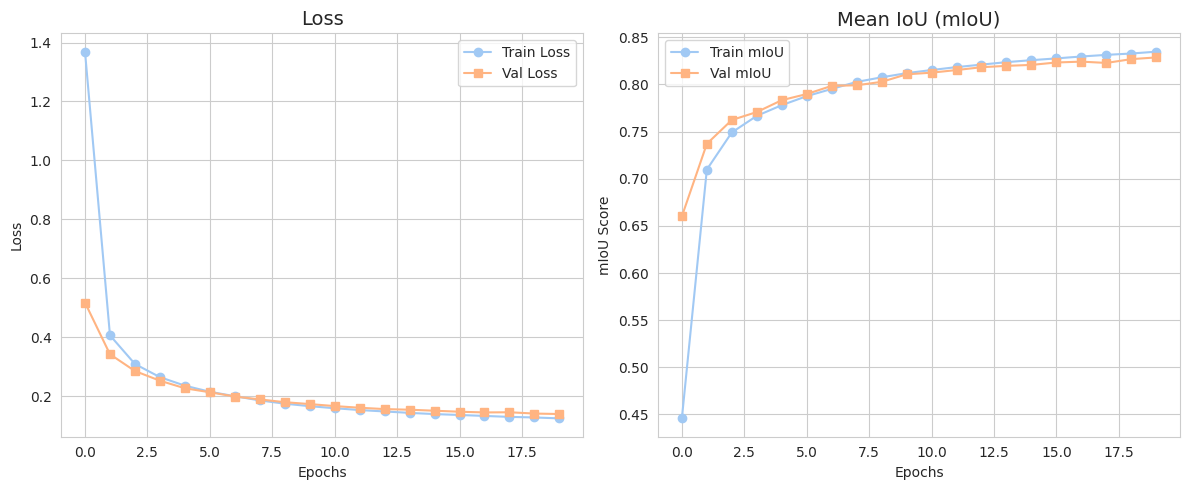

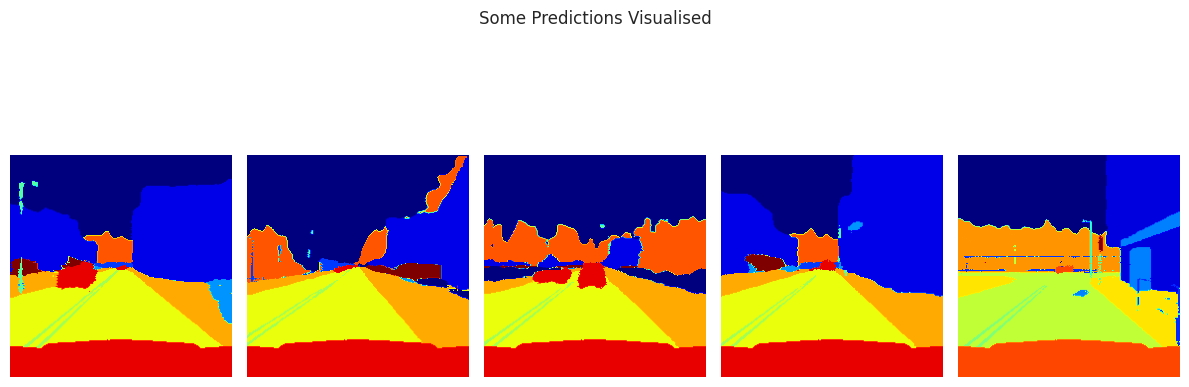

In [24]:
plot_loss_miou_outputs(*losses_mious_8s_unfrozen, x_8s_unfrozen)

## Visualising some ouptputs of unfrozen backbone models together

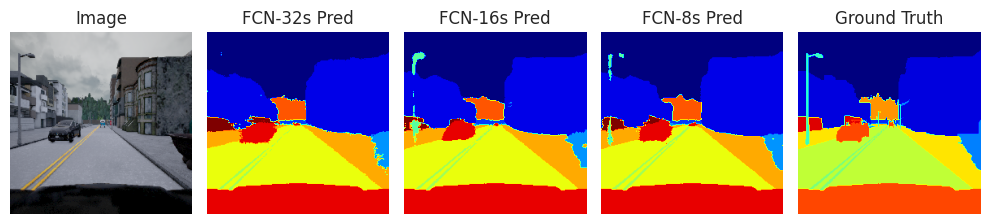

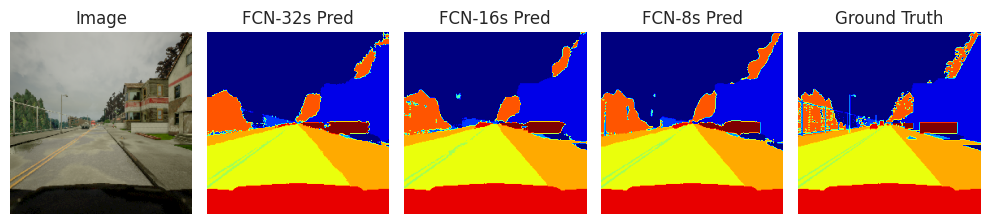

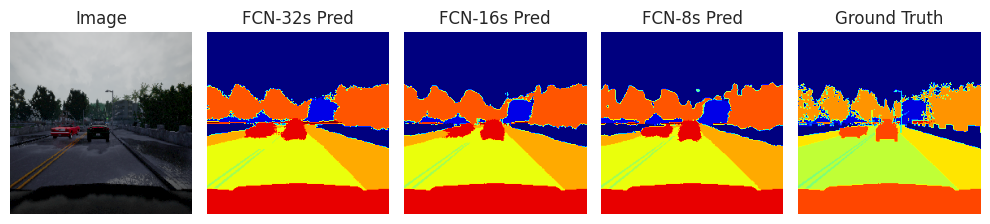

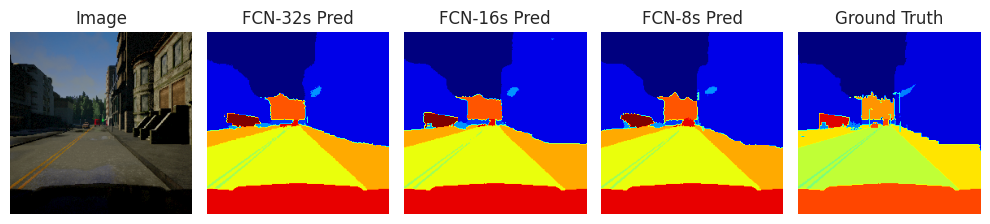

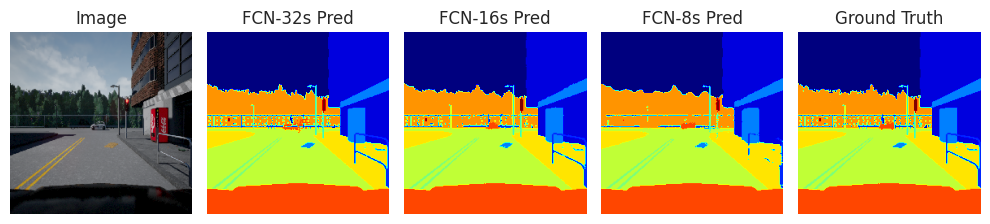

In [25]:
for i in range(5):
    fig, axes = plt.subplots(1, 5, figsize=(10, 25))
    
    axes[0].imshow(np.int32(test_images[i]))
    axes[0].set_title("Image")
    axes[0].axis('off')

    axes[1].imshow(x_32s_unfrozen[i], cmap=seg_map)
    axes[1].set_title("FCN-32s Pred")
    axes[1].axis('off')

    axes[2].imshow(x_16s_unfrozen[i], cmap=seg_map)
    axes[2].set_title("FCN-16s Pred")
    axes[2].axis('off')

    axes[3].imshow(x_8s_unfrozen[i], cmap=seg_map)
    axes[3].set_title("FCN-8s Pred")
    axes[3].axis('off')
    
    axes[4].imshow(test_masks[i], cmap=seg_map)
    axes[4].set_title("Ground Truth")
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()

## Visualising all the outuputs together for comparison

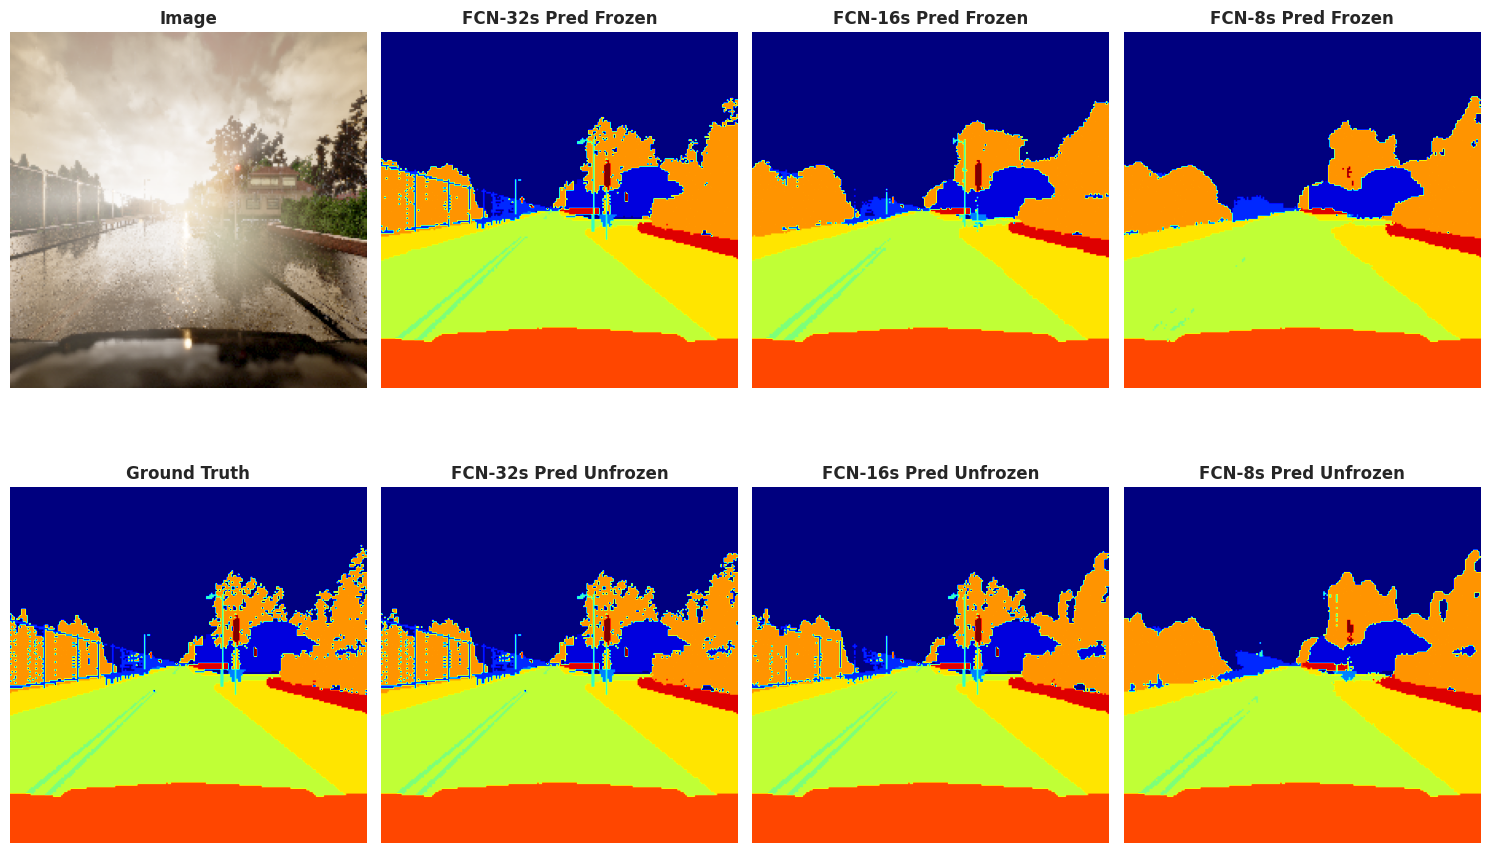

In [26]:
def visualise_segmentation_results(test_images, test_masks, x_32s, x_16s, x_8s, x_32s_unfrozen, x_16s_unfrozen, x_8s_unfrozen, seg_map, i=10):
    sns.set_style("white")
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 10))
    
    titles = ["Image", "FCN-32s Pred Frozen", "FCN-16s Pred Frozen", "FCN-8s Pred Frozen",
              "Ground Truth", "FCN-32s Pred Unfrozen", "FCN-16s Pred Unfrozen", "FCN-8s Pred Unfrozen"]
    
    images = [np.int32(test_images[i]), x_32s[i], x_16s[i], x_8s[i],
              test_masks[i], x_32s_unfrozen[i], x_16s_unfrozen[i], x_8s_unfrozen[i]]
    
    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img if title == "Image" else img, cmap=None if title == "Image" else seg_map)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualise_segmentation_results(test_images, test_masks, x_32s, x_16s, x_8s, x_32s_unfrozen, x_16s_unfrozen, x_8s_unfrozen, seg_map, 10)

## Summary Table

<style>
table {
    width: 98%;
    border-collapse: collapse;
    font-family: Arial, sans-serif;
    text-align: center;
}
th, td {
    border: 1px solid #ddd;
    padding: 10px;
}
th {
    background-color:rgb(76, 84, 175);
    color: white;
}
tr:nth-child(even) {
    background-color:rgb(234, 245, 131);
    color: black;
}
td:first-child, th:first-child {
    font-weight: bold;
}
</style>

<table>
    <tr>
        <th>Model</th>
        <th>Backbone Frozen</th>
        <th>Final Train Loss</th>
        <th>Final Train mIoU</th>
        <th>Final Val Loss</th>
        <th>Final Val mIoU</th>
        <th>Test Loss</th>
        <th>Test mIoU</th>
    </tr>
    <!-- FCN-32s -->
    <tr>
        <th rowspan=2>FCN-32s</th>
        <td>✅</td>
        <td>0.1857</td>
        <td>0.7795</td>
        <td>0.2283</td>
        <td>0.7563</td>
        <td>0.2277</td>
        <td>0.756</td>
    </tr>
    <tr>
        <td>❌</td>
        <td>0.1539</td>
        <td>0.8038</td>
        <td>0.1765</td>
        <td>0.7913</td>
        <td>0.1777</td>
        <td>0.7891</td>
    </tr>
    <!-- FCN-16s -->
    <tr>
        <th rowspan=2>FCN-16s</th>
        <td>✅</td>
        <td>0.1803</td>
        <td>0.7877</td>
        <td>0.2194</td>
        <td>0.7714</td>
        <td>0.2205</td>
        <td>0.7697</td>
    </tr>
    <tr>
        <td>❌</td>
        <td>0.1127</td>
        <td>0.8372</td>
        <td>0.1484</td>
        <td>0.8192</td>
        <td>0.1501</td>
        <td>0.8175</td>
    </tr>
    <!-- FCN-8s -->
    <tr>
        <th rowspan=2>FCN-8s</th>
        <td>✅</td>
        <td>0.1795</td>
        <td>0.8034</td>
        <td>0.2027</td>
        <td>0.7922</td>
        <td>0.204</td>
        <td>0.7904</td>
    </tr>
    <tr>
        <td>❌</td>
        <td>0.124</td>
        <td>0.8347</td>
        <td>0.1388</td>
        <td>0.8286</td>
        <td>0.1402</td>
        <td>0.8268</td>
    </tr>
</table>

## Visualising results (Code generated by Claude: https://claude.ai/share/4705352b-0176-4e00-b672-52a4f322efb0)
#### This is the visual representation of the above table

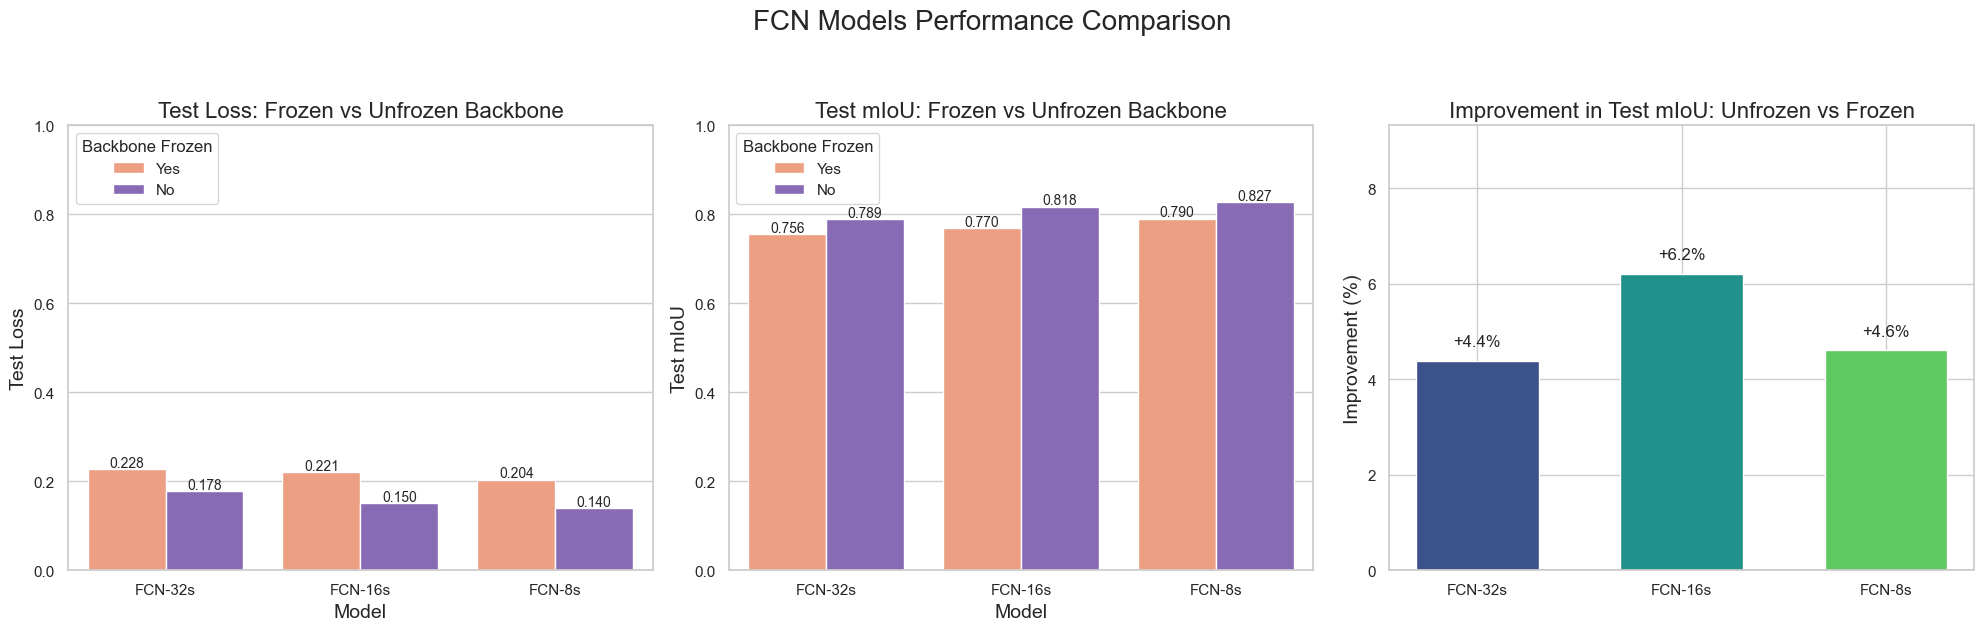

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a dataframe from the table data
data = {
    'Model': ['FCN-32s', 'FCN-32s', 'FCN-16s', 'FCN-16s', 'FCN-8s', 'FCN-8s'],
    'Backbone_Frozen': ['Yes', 'No', 'Yes', 'No', 'Yes', 'No'],
    'Test_Loss': [0.2277, 0.1777, 0.2205, 0.1501, 0.2040, 0.1402],
    'Test_mIoU': [0.7560, 0.7891, 0.7697, 0.8175, 0.7904, 0.8268]
}

df = pd.DataFrame(data)

# Set the aesthetic style
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Create a figure with subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('FCN Models Performance Comparison', fontsize=20, y=1.05)

# Plot 1: Backbone Frozen vs Unfrozen - Loss
ax1 = axes[0]
backbone_palette = {"Yes": "#FF9671", "No": "#845EC2"}

sns.barplot(x='Model', y='Test_Loss', hue='Backbone_Frozen', data=df, 
            palette=backbone_palette, ax=ax1)
ax1.set_title('Test Loss: Frozen vs Unfrozen Backbone', fontsize=16)
ax1.set_xlabel('Model', fontsize=14)
ax1.set_ylabel('Test Loss', fontsize=14)
ax1.legend(title='Backbone Frozen', loc='upper left')
ax1.set_ylim(0, 1)

# Add value labels
for p in ax1.patches:
    height = p.get_height()
    if height == 0:
        continue
    ax1.text(p.get_x() + p.get_width()/2., height + 0.005,
             f'{height:.3f}',
             ha="center", fontsize=10)

# Plot 2: Backbone Frozen vs Unfrozen - mIoU
ax2 = axes[1]
sns.barplot(x='Model', y='Test_mIoU', hue='Backbone_Frozen', data=df, 
            palette=backbone_palette, ax=ax2)
ax2.set_title('Test mIoU: Frozen vs Unfrozen Backbone', fontsize=16)
ax2.set_xlabel('Model', fontsize=14)
ax2.set_ylabel('Test mIoU', fontsize=14)
ax2.legend(title='Backbone Frozen', loc='upper left')
ax2.set_ylim(0, 1)

# Add value labels
for p in ax2.patches:
    height = p.get_height()
    if height == 0:
        continue
    ax2.text(p.get_x() + p.get_width()/2., height + 0.005,
             f'{height:.3f}',
             ha="center", fontsize=10)

# Plot 3: Improvement percentage from frozen to unfrozen
ax3 = axes[2]
x = np.arange(3)
width = 0.6

# Calculate frozen and unfrozen values for each model
models = ['FCN-32s', 'FCN-16s', 'FCN-8s']
frozen_miou = []
unfrozen_miou = []

for model in models:
    frozen = df[(df['Model'] == model) & (df['Backbone_Frozen'] == 'Yes')]['Test_mIoU'].values[0]
    unfrozen = df[(df['Model'] == model) & (df['Backbone_Frozen'] == 'No')]['Test_mIoU'].values[0]
    frozen_miou.append(frozen)
    unfrozen_miou.append(unfrozen)

# Calculate percentage improvement
improvement = [(unfrozen - frozen) / frozen * 100 for frozen, unfrozen in zip(frozen_miou, unfrozen_miou)]

# Bar chart showing percentage improvement
bars = ax3.bar(x, improvement, width=width, color=sns.color_palette("viridis", 3))
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.set_ylabel('Improvement (%)', fontsize=14)
ax3.set_title('Improvement in Test mIoU: Unfrozen vs Frozen', fontsize=16)

# Set expanded y-axis limits to increase the height of the plot
max_improvement = max(improvement)
ax3.set_ylim([0, max_improvement * 1.5])  # Increase y-axis range by 50%

# Add percentage labels
for i, v in enumerate(improvement):
    ax3.text(i, v + (max_improvement * 0.05), f"+{v:.1f}%", ha='center', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

## Observations

### 1. Architectures
- **FCN-32s**: Upsamples 32x from `pool5`. Coarsest predictions.
- **FCN-16s**: Combines `pool5` and `pool4`, then upsamples 16x. Adds mid-level detail.
- **FCN-8s**: Combines `pool5`, `pool4`, and `pool3`, then upsamples 8x. Most detailed.

### 2. Performance
- **Best Results**: FCN-8s > FCN-16s > FCN-32s in terms of mIoU across all splits.
- **Backbone Freezing**:
  - Unfreezing improves performance significantly.
  - Example: FCN-8s test mIoU increases from **0.7904** (frozen) to **0.8268** (unfrozen).
  - Fine-tuning helps adapt ImageNet features to the segmentation task.

- **Visual vs Metric**:
  - FCN-32s, despite lower mIoU, sometimes detects fine structures (e.g., poles) better.

**Conclusion**: FCN-8s with an unfrozen backbone gives the best results overall.